In [323]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
#import pickle
from prophet import Prophet
import openpyxl



In [324]:

df = pd.read_csv("brentdb.csv", sep=';', decimal = ',', thousands = '.')
df = df.rename(columns={'Preço - petróleo bruto - Brent (FOB)': 'Brent (F0B)'})
df['Data'] = pd.to_datetime(df['Data'], origin='1899-12-30', unit='D')


df.head()

Data  Brent (F0B)
0 2024-04-29        88.44
1 2024-04-26        89.95
2 2024-04-25        88.10
3 2024-04-24        89.02
4 2024-04-23        88.29

In [325]:
df.isna().sum()

Data           0
Brent (F0B)    0
dtype: int64

In [326]:
df.describe()

Data   Brent (F0B)
count                          11160  11160.000000
mean   2006-08-01 23:18:34.838709760     52.998235
min              1987-05-20 00:00:00      9.100000
25%              1998-05-14 18:00:00     20.480000
50%              2007-03-22 12:00:00     48.170000
75%              2014-12-13 06:00:00     76.280000
max              2024-04-29 00:00:00    143.950000
std                              NaN     33.229801

In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11160 entries, 0 to 11159
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Data         11160 non-null  datetime64[ns]
 1   Brent (F0B)  11160 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 174.5 KB


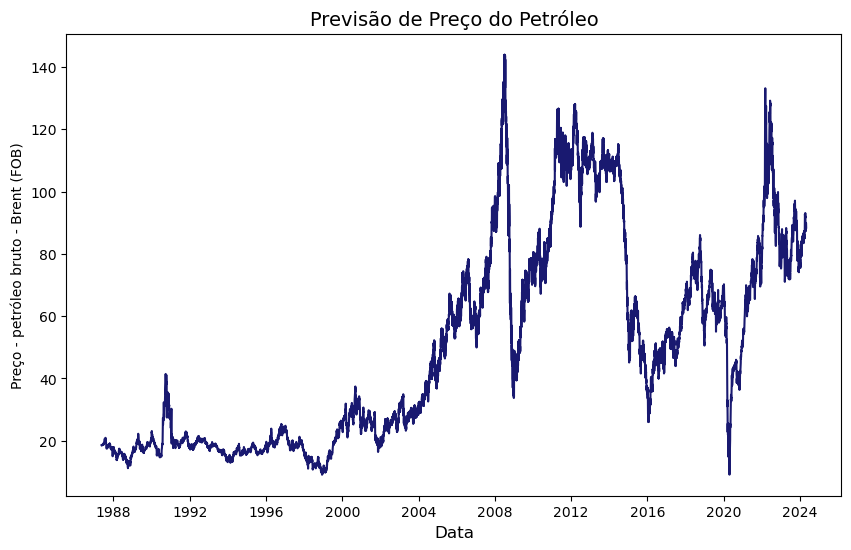

In [328]:
# Criando o gráfico de linha
plt.figure(figsize=(10, 6))
plt.errorbar(df['Data'], df['Brent (F0B)'], color='midnightblue')


# Adicionando título e rótulos aos eixos
plt.title('Previsão de Preço do Petróleo', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço - petróleo bruto - Brent (FOB)')

plt.show()

# Seasonal Decompose

In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11160 entries, 0 to 11159
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Data         11160 non-null  datetime64[ns]
 1   Brent (F0B)  11160 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 174.5 KB


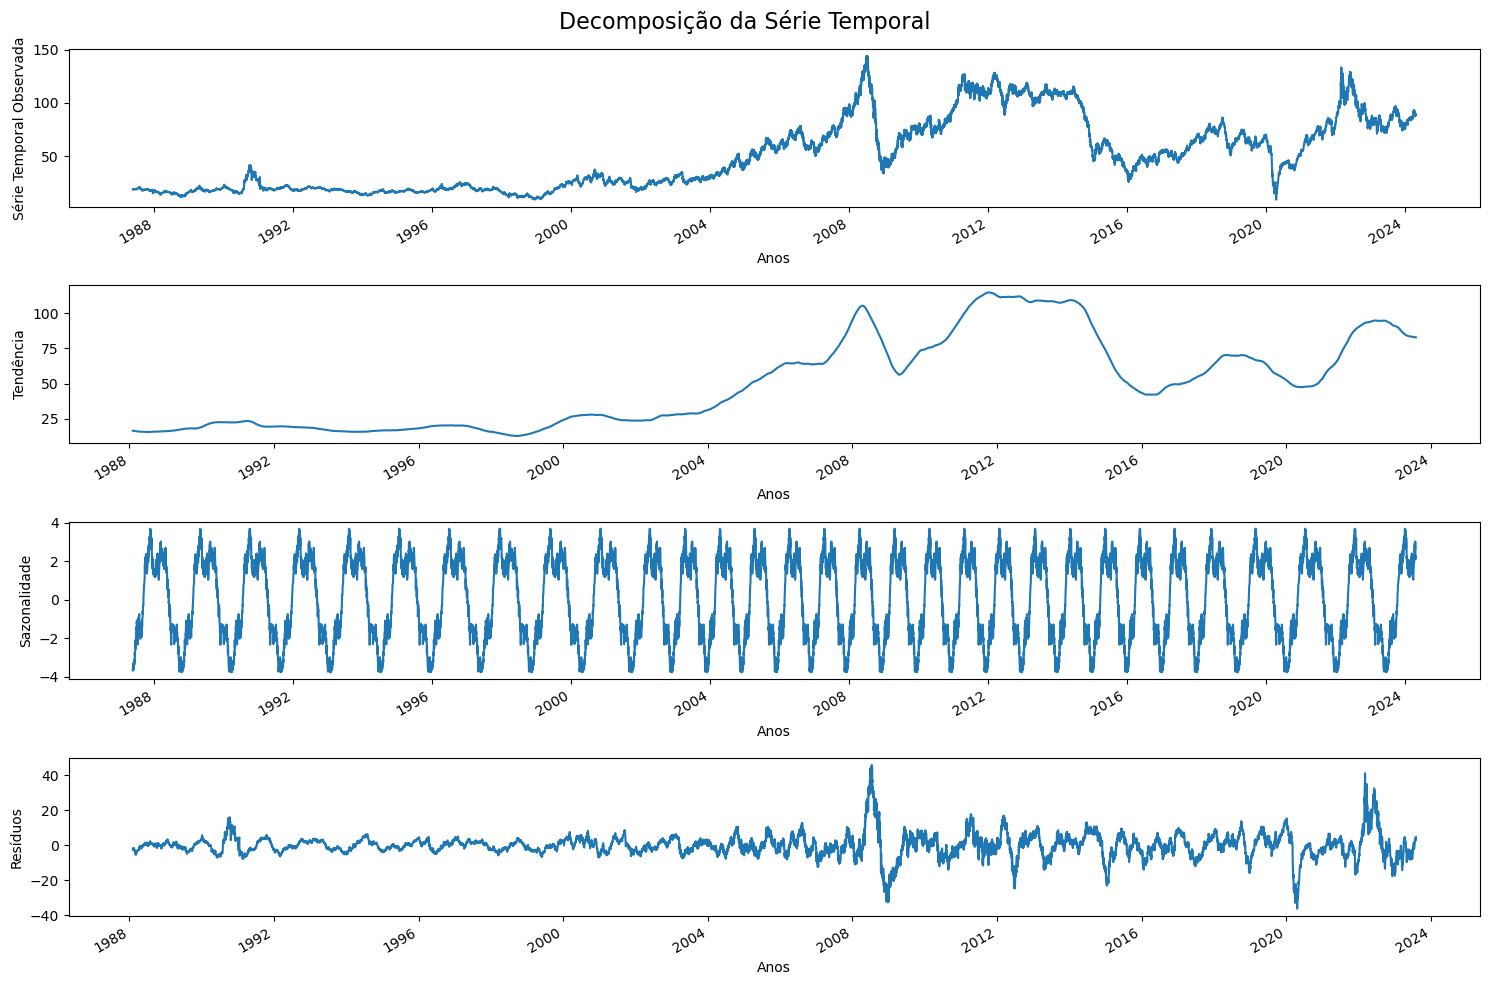

In [330]:
df2 = df.set_index('Data')

resultados = seasonal_decompose(df2['Brent (F0B)'], period=365)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
resultados.observed.plot(ax=ax1)
ax1.set_ylabel('Série Temporal Observada')
ax1.set_xlabel('Anos')

resultados.trend.plot(ax=ax2)
ax2.set_ylabel('Tendência')
ax2.set_xlabel('Anos')

resultados.seasonal.plot(ax=ax3)
ax3.set_ylabel('Sazonalidade')
ax3.set_xlabel('Anos')

resultados.resid.plot(ax=ax4)
ax4.set_ylabel('Resíduos')
ax4.set_xlabel('Anos')

plt.suptitle('Decomposição da Série Temporal', fontsize=16)
plt.tight_layout()
plt.show()

In [331]:
window = 30  # Janela de 0 dias
df0 = df.copy()
df0['DesvioPadrao'] = df0['Brent (F0B)'].rolling(window=window).std()
df0['MM30'] = df0['Brent (F0B)'].rolling(30).mean().shift() #média móvel
df0['MM180'] = df0['Brent (F0B)'].rolling(180).mean().shift() #média móvel


In [332]:
df

Data  Brent (F0B)
0     2024-04-29        88.44
1     2024-04-26        89.95
2     2024-04-25        88.10
3     2024-04-24        89.02
4     2024-04-23        88.29
...          ...          ...
11155 1987-05-26        18.63
11156 1987-05-25        18.60
11157 1987-05-22        18.55
11158 1987-05-21        18.45
11159 1987-05-20        18.63

[11160 rows x 2 columns]

In [333]:
df0.tail()

Data  Brent (F0B)  DesvioPadrao       MM30      MM180
11155 1987-05-26        18.63      0.261401  18.929000  18.257611
11156 1987-05-25        18.60      0.241103  18.900667  18.270000
11157 1987-05-22        18.55      0.218813  18.870667  18.281667
11158 1987-05-21        18.45      0.209605  18.839667  18.295278
11159 1987-05-20        18.63      0.194803  18.810333  18.307889

In [334]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df0['Data'], y=df0['Brent (F0B)'], mode='lines', name='Brent'))

fig.add_trace(go.Scatter(x=df0['Data'], y=df0['MM30'], mode='lines', name='MM0'))

fig.add_trace(go.Scatter(x=df0['Data'], y=df0['MM180'], mode='lines', name='MM180'))



fig.update_layout(
    title="Preço do Petroleo e sua médias moveis",
    xaxis_title="Date",
    yaxis_title="Price",
    legend_title="Legend",
    template="plotly_dark",
    width=1200, 
    height=800
)

# Show plot
fig.show()


c:\Users\igorm\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [335]:
fig = go.Figure()

# Brent prices
fig.add_trace(go.Scatter(x=df0['Data'], y=df0['DesvioPadrao'], mode='lines', name='Brent'))


# Update layout
fig.update_layout(
    title="Desvio Padrao do Preço do Petroleo",
    xaxis_title="Date",
    yaxis_title="Price",
    legend_title="Legend",
    template="plotly_dark",
    width=1200,  # Width of the figure in pixels
    height=800
)

# Show plot
fig.show()


In [336]:
# Caminho do arquivo Excel
caminho_arquivo = 'iea.xlsx'
nome_aba = 'TimeSeries_1971-2022'

# Ler o arquivo Excel e acessar a aba TimeSeries a partir da linha 2
#dados = pd.read_excel("./techvenv\iea.xlsx", sheet_name='TimeSeries_1971-2022', header=1)


dfs1 = pd.read_csv("shanghai.csv", sep=',', decimal = ',', thousands = '.')

dfs2 = pd.read_csv("shanghai2.csv", sep=',', decimal = ',', thousands = '.')
dfs = pd.concat([dfs1, dfs2], ignore_index=True)

dfs.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8155 entries, 0 to 8154
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      8155 non-null   int64  
 1   Último    8155 non-null   float64
 2   Abertura  8155 non-null   float64
 3   Máxima    8155 non-null   float64
 4   Mínima    8155 non-null   float64
 5   Vol.      7146 non-null   object 
 6   Var%      8155 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 446.1+ KB


In [337]:
dfs

Data   Último  Abertura   Máxima   Mínima   Vol.    Var%
0     19052011  2859.57   2879.39  2884.14  2856.83  7,70B  -0,46%
1     18052011  2872.77   2846.72  2877.43  2843.68  7,68B   0,70%
2     17052011  2852.77   2846.45  2869.23  2821.20  9,48B   0,13%
3     16052011  2849.07   2864.38  2877.09  2846.31  8,46B  -0,76%
4     13052011  2871.03   2846.31  2871.99  2832.25  9,32B   0,95%
...        ...      ...       ...      ...      ...    ...     ...
8150  26052011  2736.53   2755.39  2764.89  2734.54  7,87B  -0,19%
8151  25052011  2741.74   2764.56  2771.18  2737.33  7,44B  -0,92%
8152  24052011  2767.06   2766.06  2771.75  2744.78  7,49B  -0,27%
8153  23052011  2774.57   2853.29  2853.29  2771.12  9,86B  -2,93%
8154  20052011  2858.46   2858.31  2866.76  2850.45  7,07B  -0,04%

[8155 rows x 7 columns]

### Funções a serem utilizadas

In [338]:
def formata_numero(valor, prefixo = ''):
    for unidade in ['', 'mil']:
        if valor <1000:
            return f'{prefixo} {valor:.2f} {unidade}'
        valor /= 1000
    return f'{prefixo} {valor:.2f} milhões'

In [339]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum()/np.abs(y_true).sum()

In [340]:
def plotagem(dados2):
    # Filtra os dados pelo país "World" e o fluxo "Total final consumption (PJ)"
    dadosf = dados2[(dados2["Country"] == "World") & (dados2["Flow"] == "Total final consumption (PJ)")]

    # Cria uma figura vazia
    fig = go.Figure()

    # Itera sobre cada produto único e adiciona a linha correspondente ao gráfico
    for product in dadosf["Product"].unique():
        dados_produto = dadosf[dadosf["Product"] == product]
        d2 = dados_produto.iloc[:, 3::].T.reset_index()
        
        if d2.shape[1] == 2:  # Verifica se há exatamente 2 colunas
            d2.columns = ["Ano", "Valor"]
            
            # Adiciona a linha ao gráfico existente
            fig.add_trace(go.Scatter(x=d2["Ano"], y=d2["Valor"], mode='lines', name=product))

    # Atualiza o título e adiciona a legenda
    fig.update_layout(title="Consumo Energético Global por Produto (KTOE)",
                    xaxis_title="Ano",
                    yaxis_title="Valor",
                    legend_title="Produto",
                    template="plotly",
                    width=600,
                    height=500)

    return fig



In [341]:
def calcular_metricas(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    wmape_value = wmape(y_true, y_pred)
    return mae, mse, wmape_value


## Modelo de ML Naive


In [342]:
df['unique_id'] = 1

treino = df.loc[df['Data']<"2024-01-18"].rename(columns={'Data': 'ds', 'Brent (F0B)': 'y'})
valid = df.loc[(df['Data']>="2024-01-18")].rename(columns={'Data': 'ds', 'Brent (F0B)': 'y'})


In [343]:
model_naive = StatsForecast(models=[Naive()],freq='D', n_jobs=-1)
model_naive.fit(treino)

StatsForecast(models=[Naive])

In [360]:
h = valid['ds'].nunique()
forecast_df_naive = model_naive.predict(h=h, level=[90])
forecast_df_naive = forecast_df_naive.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_df_naive.dropna(inplace=True)
forecast_df_naive.head()



c:\Users\igorm\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



unique_id         ds      Naive  Naive-lo-90  Naive-hi-90      y
0          1 2024-01-18  78.879997    76.483101    81.276894  81.04
1          1 2024-01-19  78.879997    75.490273    82.269722  80.71
4          1 2024-01-22  78.879997    73.520370    84.239624  81.70
5          1 2024-01-23  78.879997    73.008820    84.751175  82.04
6          1 2024-01-24  78.879997    72.538399    85.221596  82.15

In [345]:
fig_naive = model_naive.plot(treino, forecast_df_naive, level=['90'], engine='plotly')
fig_naive.update_layout(
    width=1000,  # Largura em pixels
    height=500,  # Altura em pixels
)

c:\Users\igorm\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [356]:
mae_naive, mse_naive, wmape_naive = calcular_metricas(forecast_df_naive['y'], forecast_df_naive['Naive'])
print(f'As Metricas para o modelo foram: wmape: {wmape_naive:.3f}%, mae: {mae_naive:.2f}%, mse {mse_naive:.2f}%')

As Metricas para o modelo foram: wmape: 0.061%, mae: 5.15%, mse 29.94%


## Seasonal Naive

In [347]:
model_s = StatsForecast(models=[SeasonalNaive(season_length=30)],freq='D', n_jobs=-1)
model_s.fit(treino)

forecast_dfs = model_s.predict(h=h, level=[90])
forecast_dfs = forecast_dfs.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_dfs = pd.DataFrame(data=forecast_dfs)
forecast_dfs = forecast_dfs.dropna()

fig_snaive = model_s.plot(treino, forecast_dfs, level=[90], engine='plotly')
fig_snaive.update_layout(
    width=1000,  # Largura em pixels
    height=500,  # Altura em pixels
)

c:\Users\igorm\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

c:\Users\igorm\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [348]:
mae_snaive, mse_snaive, wmape_snaive = calcular_metricas(forecast_dfs['y'], forecast_dfs['SeasonalNaive'])
print(f'As Metricas para o modelo foram: wmape: {wmape_snaive:.3f}, mae: {mae_snaive:.2f}%, mse {mse_snaive:.2f}%')

As Metricas para o modelo foram: wmape: 0.076, mae: 6.40%, mse 48.64%


## Seasonal Window Average

In [349]:
treino2 = treino.set_index('ds').resample('D').ffill()
valid2 = valid.set_index('ds').resample('D').ffill()
treino2.reset_index(inplace=True)
valid2.reset_index(inplace=True)

In [350]:
model_sm = StatsForecast(models=[SeasonalWindowAverage(season_length=30, window_size=60)], freq='D', n_jobs=-1)
model_sm.fit(treino2)
h = valid2['ds'].nunique()
forecast_dfsm = model_sm.predict(h=h)


forecast_dfsm = forecast_dfsm.reset_index().merge(valid2, on=['ds', 'unique_id'], how='left')
forecast_dfsm = pd.DataFrame(data=forecast_dfsm)
forecast_dfsm = forecast_dfsm.dropna()

model_sm.plot(treino2, forecast_dfsm, engine='plotly')

c:\Users\igorm\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

c:\Users\igorm\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [351]:
fig_waverage = model_sm.plot(treino2, forecast_dfsm, engine='plotly')
fig_waverage.update_layout(
    width=1000,  # Largura em pixels
    height=500,  # Altura em pixels
)

c:\Users\igorm\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [352]:
forecast_dfsm.head(2)

unique_id         ds     SeasWA      y
0          1 2024-01-18  72.200836  81.04
1          1 2024-01-19  72.300331  80.71

In [353]:
mae_SeasWA, mse_SeasWA, wmape_SeasWA = calcular_metricas(forecast_dfsm['y'], forecast_dfsm['SeasWA'])
print(f'As Metricas para o modelo foram: wmape: {wmape_SeasWA:.3f}, mae: {mae_SeasWA:.2f}%, mse {mse_SeasWA:.2f}%')

As Metricas para o modelo foram: wmape: 0.155, mae: 13.31%, mse 188.77%


## Prophet

In [354]:
model_prophet = Prophet(daily_seasonality=True) 
model_prophet.fit(treino.drop('unique_id', axis = 1))

AttributeError: 'Prophet' object has no attribute 'stan_backend'

In [ ]:
# Crie um dataframe com as datas futuras para as quais você deseja fazer previsões
datas_futuras = model_prophet.make_future_dataframe(periods=365)  # Pode ajustar a quantidade de dias no futuro

# Faça as previsões
previsao = model_prophet.predict(datas_futuras)

# Merge dos dataframes de previsão com os valores reais usando a coluna 'ds'
forecast_prophet = pd.merge(previsao, valid, on='ds', how='left')
forecast_prophet.rename(columns={'y_y': 'y'}, inplace=True)
fig_prophet = model_prophet.plot(forecast_prophet)
forecast_prophet = forecast_prophet.dropna()


ds      y
71    2024-01-17  78.88
72    2024-01-16  80.15
73    2024-01-15  79.76
74    2024-01-12  79.89
75    2024-01-11  80.21
...          ...    ...
11155 1987-05-26  18.63
11156 1987-05-25  18.60
11157 1987-05-22  18.55
11158 1987-05-21  18.45
11159 1987-05-20  18.63

[11089 rows x 2 columns]

In [ ]:
mae_prophet, mse_prophet, wmape_prophet = calcular_metricas(forecast_prophet['y'], forecast_prophet['yhat'])
wmape_prophet = f"{wmape_prophet:.3f}%"


NameError: name 'forecast_prophet' is not defined